In [1]:
import numpy as np
import os
import re

import CDEF

import scipy.optimize
from scipy.optimize import root, Bounds

import time

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

from build123d import export_stl, Sphere, Solid, Shell, Face, Wire, fillet
from ocp_vscode import show


def sphere_curve(radius, N=30000): 
    sphere = Sphere(radius)
    mesh = build123d_to_mesh(sphere)
    cloud = CDEF.stl_cloud(mesh, N, sequence='halton')
    curve = CDEF.scattering_mono(cloud, selfcorrelation=True)
    return curve

def bipyramid(fillet_radius, R, h, base_corners=5, center=(0,0,0), rotation=0.0):
    from build123d import Solid, Shell, Face, Wire, export_stl, fillet
    from scipy.spatial import ConvexHull
    import numpy as np

    def bipyramid_vertices(R, h, base_corners=5, center=(0,0,0), rotation=0.0):
        """Generate vertices of a bipyramid with a variable amount of base corners.

        Args:
            R (float): radius of the base.
            h (float): height of the apices above and below the base plane.
            center (tuple): (x, y, z) coordinates of the bipyramid center.
            rotation (float): rotation angle in radians applied to the base pentagon.

        Returns:
            List of 7 tuples [(x,y,z), ...] representing the bipyramid vertices.
        """
        cx, cy, cz = center
        vertices = []
        
        # 5 vertices of pentagonal base in XY plane with rotation
        for i in range(base_corners):
            angle = 2 * np.pi * i / base_corners + rotation
            x = cx + R * np.cos(angle)
            y = cy + R * np.sin(angle)
            z = cz
            vertices.append((x, y, z))
        
        # apex vertex at +h and -h
        vertices.append((cx, cy, cz + h))
        vertices.append((cx, cy, cz - h))
        
        return vertices

    vertices = bipyramid_vertices(R=R, h=h, base_corners=base_corners, center=center, rotation=rotation)

    # Create a convex hull from the vertices
    hull = ConvexHull(vertices).simplices.tolist()

    # Create faces from the vertex indices
    faces = []
    for face_vertex_indices in hull:
        corner_vertices = [vertices[i] for i in face_vertex_indices]
        faces.append(Face(Wire.make_polygon(corner_vertices)))

    # Create the solid from the Faces
    bipy = Solid(Shell(faces)).clean()
    if fillet_radius > 0:
        bipy = fillet(bipy.edges(), radius=fillet_radius)
    return bipy


def build123d_to_mesh(shape, tolerance=1e-3):
    all_tris = []
    for f in shape.faces():
        tess = f.tessellate(tolerance)
        # Case 1: tess returns (vertices, triangles)
        if isinstance(tess, tuple) and len(tess) == 2:
            vertices, triangles = tess
            # Convert each vertex to (x,y,z)
            coords = [ (v.X, v.Y, v.Z) if hasattr(v, "X") else tuple(v) for v in vertices ]
            for tri in triangles:
                all_tris.append([ coords[i] for i in tri ])
        # Case 2: tess returns list of triangles directly
        else:
            for tri in tess:
                # Convert each Vector to tuple if needed
                all_tris.append([ (v.X, v.Y, v.Z) if hasattr(v, "X") else tuple(v) for v in tri ])
    return np.array(all_tris, dtype=np.float64)


# Function to make 3D axes equal
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres."""
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    centers = np.mean(limits, axis=1)
    max_range = 0.5 * np.max(limits[:,1] - limits[:,0])
    for center, setter in zip(centers, [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d]):
        setter(center - max_range, center + max_range)


def next_folder(prefix, base_dir="."):
    """
    Find the next folder with prefix_xxxx in base_dir.
    If none exists, create prefix_0000.
    Otherwise, create prefix_<max+1> with leading zeros.
    """
    # Regex to match prefix_XXXX where XXXX are digits
    pattern = re.compile(rf"^{prefix}_(\d{{4}})$")
    
    max_num = -1
    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            num = int(match.group(1))
            max_num = max(max_num, num)
    
    # Determine next number
    next_num = max_num + 1 if max_num >= 0 else 0
    folder_name = f"{prefix}_{next_num:04d}"
    folder_path = os.path.join(base_dir, folder_name)
    
    os.makedirs(folder_path, exist_ok=False)  # fail if it already exists
    return folder_path


def plot_fitresults(data, fit_result, unitscattering, distribution, N):
    #q-range of fit
    qvec = np.logspace(-3,0,1000)

    fit = CDEF.scattering_model(unitscattering, qvec, *fit_result.x, distribution)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

    r = fit_result.x[1]
    r_bipy = 2*r / (1 + np.cos(np.pi/5))
    e_bipy = 2*r_bipy * np.sin(np.pi/5)

    ax[0].set_title(f'bipyramid mean side length = {e_bipy:.1f} nm, {N} pts')
    ax[0].set_xscale('log')
    ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
    ax[0].set_yscale('log')

    #Frame limits
    ax[0].set_ylim([1e-1, 1e5])
    ax[0].set_xlim([3e-2, 1e0])

    ax[0].errorbar(data[:,0], data[:,1], 
                yerr = data[:,2], fmt='.', ecolor='k', 
                capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
    ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

    ax[0].legend()

    #########################################
    ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
    ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

    #Frame limits
    ax[1].set_ylim([0.85, 1.15])

    ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
                label = 'Experimental data', zorder=1)

    ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

    plt.show()

    # fig.savefig(os.path.join("plots", f"pentagonal_bipyramid.png"))

718


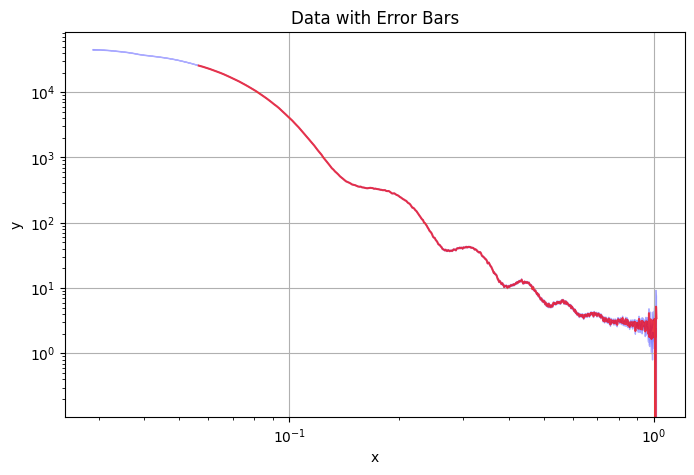

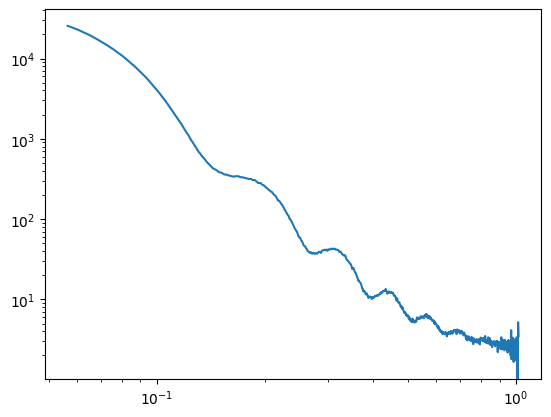

In [2]:
# Read measured data 

data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_44.7.dat")

x0 = 20
print(len(data))
x = data[:,0]
y = data[:,1]
yerr = data[:,3]

plt.figure(figsize=(8,5))
# plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, ecolor='red', markerfacecolor='blue', markersize=4)
# plt.plot(x, y, 'b-', label='y', alpha=0.3)
plt.fill_between(x, y - yerr, y + yerr, color='blue', alpha=0.3, label='uncertainty')
plt.plot(x[x0:], y[x0:], 'r-', label='y', alpha=0.7)
plt.xlabel("x")
plt.ylabel("y")
plt.yscale("log")
plt.xscale("log")
plt.title("Data with Error Bars")
plt.grid(True)
plt.show()

data = data[x0:,:]

fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1])

# show(Sphere(1), port=3939)

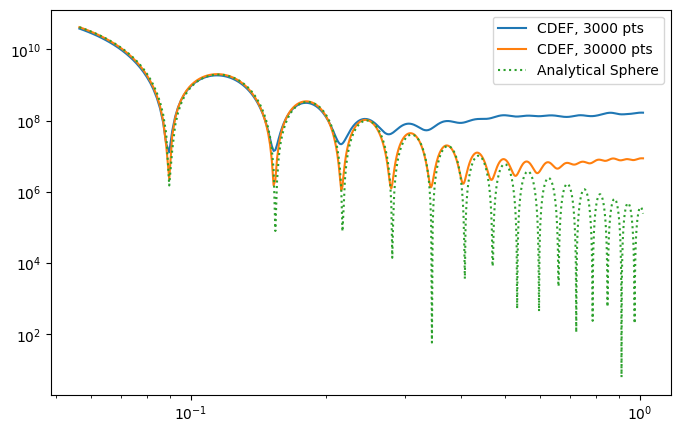

In [3]:
%load_ext autoreload
%autoreload 2

import CDEF

N = 3000
distribution = 'lognormal'
N_C, mean, sigma, c0 =  30e-7, 50, 1e-8, 0
inital_guess = N_C, mean, sigma, c0

q = data[:,0]


tic = time.time()
unitscattering = sphere_curve(1, N)
polyscattering = CDEF.scattering_poly(unitscattering, q, mean, sigma, N, distribution=distribution)
qr = q * mean
analyticalsphere = np.column_stack((q, (3 * (np.sin(qr) - qr * np.cos(qr)) / (qr**3))**2))
analyticalsphere[:,1] *= (polyscattering[0,1] / analyticalsphere[0,1])

plt.figure(figsize=(8,5))
# plt.loglog(polyscattering[:,0], polyscattering[:,1], label='Poly Scattering')
plt.loglog(polyscattering[:,0], polyscattering[:,1], label=f'CDEF, {N} pts')
# plt.loglog(analyticalsphere[:,0], analyticalsphere[:,1], '--', label='Analytical Sphere')
# plt.legend()
# fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, unitscattering, distribution), 
#                                      method = 'Powell', options={'disp' : True})
# toc = time.time()
# print('Calculation time = {} s'.format(toc-tic))
# print(f'fit results = {fit_result.x}')
# print(f'chi_squared = {CDEF.chi_squared(fit_result.x, data, unitscattering, distribution)}')


# plot_fitresults(data, fit_result, unitscattering, distribution, N)

N = 30000

tic = time.time()
unitscattering = sphere_curve(1, N)
polyscattering = CDEF.scattering_poly(unitscattering, q, mean, sigma, N, distribution=distribution)
# q = np.logspace(-2,1,1000)
# q = np.logspace(np.log10(5e-2),np.log10(3),1000)
qr = q * mean
analyticalsphere = np.column_stack((q, (3 * (np.sin(qr) - qr * np.cos(qr)) / (qr**3))**2))
analyticalsphere[:,1] *= (polyscattering[0,1] / analyticalsphere[0,1])

# plt.figure(figsize=(8,5))
# plt.loglog(polyscattering[:,0], polyscattering[:,1], label='Poly Scattering')
plt.loglog(polyscattering[:,0], polyscattering[:,1], label=f'CDEF, {N} pts')
plt.loglog(analyticalsphere[:,0], analyticalsphere[:,1], ':', label='Analytical Sphere')
plt.legend()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calculation time = 0.2444305419921875 s
Calculation time = 0.3666672706604004 s
Calculation time = 0.7484307289123535 s
Calculation time = 2.5388286113739014 s
Calculation time = 12.538437366485596 s
Calculation time = 103.93508648872375 s


Text(0.5, 1.0, 'unit sphere scattering')

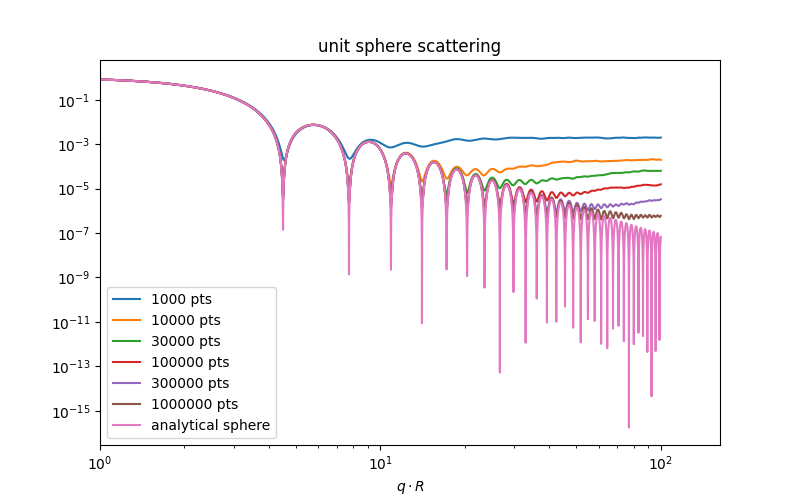

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

distribution = 'lognormal'
N_C, mean, sigma, c0 =  30e-7, 50, 1e-8, 0
inital_guess = N_C, mean, sigma, c0
# q = data[:,0]

plt.figure(figsize=(8,5))


for N in [1000, 10000, 30000, 100000, 300000, 1000000]:

    tic = time.time()
    unitscattering = sphere_curve(1, N)
    # polyscattering = CDEF.scattering_poly(unitscattering, q, mean, sigma, N, distribution=distribution)
    # qr = q * mean
    # analyticalsphere = np.column_stack((q, (3 * (np.sin(qr) - qr * np.cos(qr)) / (qr**3))**2))
    # analyticalsphere[:,1] *= (polyscattering[0,1] / analyticalsphere[0,1])
    plt.loglog(unitscattering[:,0], unitscattering[:,1], label=f'{N} pts')
    toc = time.time()
    print('Calculation time = {} s'.format(toc-tic))

q = unitscattering[:,0]
qr = q * 1
analyticalsphere = np.column_stack((q, (3 * (np.sin(qr) - qr * np.cos(qr)) / (qr**3))**2))
analyticalsphere[:,1] *= (unitscattering[0,1] / analyticalsphere[0,1])
plt.loglog(analyticalsphere[:,0], analyticalsphere[:,1], label=f'analytical sphere')
plt.xlim(xmin=1)
plt.legend()
plt.xlabel(r"$q \cdot R$")
plt.title("unit sphere scattering")

val_at_x = CDEF.chi_squared(fit_result.x, data, unitscattering, distribution)
print("Function at fit_result.x:", val_at_x)
print("fit_result.fun:", fit_result.fun)
print("Difference:", val_at_x - fit_result.fun)

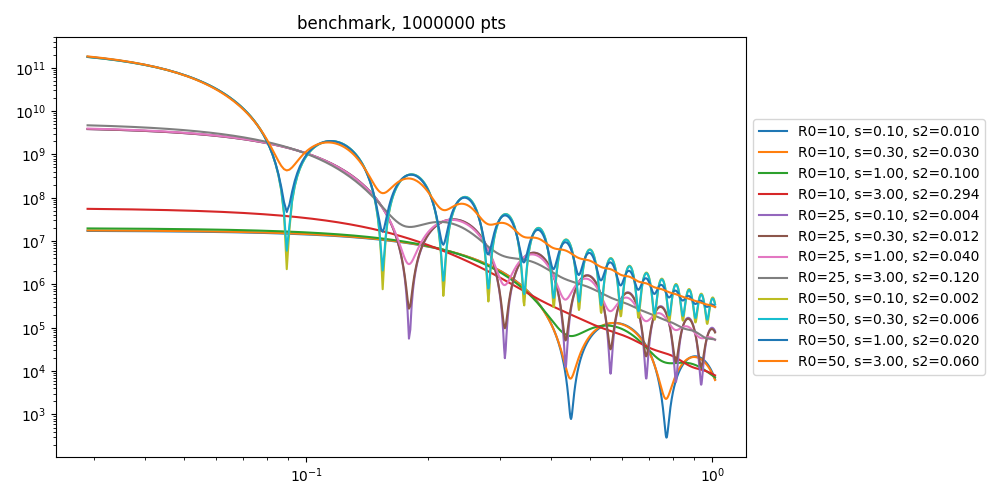

In [5]:
N = 1000000

distribution = 'lognormal'
N_C, mean, sigma, c0 =  30e-7, 50, 2, 0
inital_guess = N_C, mean, sigma, c0
sigma2 = np.sqrt(np.log(sigma**2/mean**2 + 1))

# load data just to get realistic q range
data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_44.7.dat")
q = data[:,0]
# q = unitscattering[:,0]

plt.figure(figsize=(10,5))

for mean in [10, 25, 50]:
    for sigma in [.1, .3, 1, 3]:

        sigma2 = np.sqrt(np.log(sigma**2/mean**2 + 1))
        # unitscattering = sphere_curve(1, N)
        polyscattering = CDEF.scattering_poly(unitscattering, q, mean, sigma, 1000, distribution=distribution)

        plt.loglog(polyscattering[:,0], polyscattering[:,1], label=f'R0={mean:.0f}, s={sigma:.2f}, s2={sigma2:.3f}')

        polyscattering = np.column_stack([polyscattering, np.sqrt(polyscattering[:, 1])])

        np.savetxt(
            f"benchmark_R{mean:.0f}_std{sigma:.1f}_sigma{sigma2:.2g}.dat",
            polyscattering,
            fmt="%.6e\t%.6e\t%.6e",  # control formatting
            header="q\tI\tIerr",
            comments="#"                    # ensure header starts with '#'
        )

plt.title(f"benchmark, {N} pts")
plt.legend(
    loc="center left",           # position relative to the bounding box
    bbox_to_anchor=(1, 0.5)      # (x, y) coordinates relative to axes
)
plt.tight_layout()  

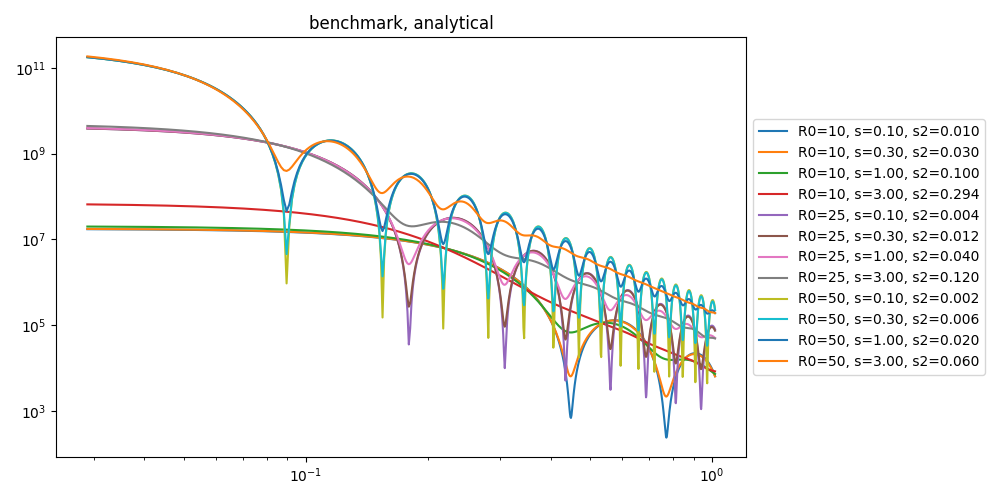

In [6]:
N = 1000000

distribution = 'lognormal'
N_C, mean, sigma, c0 =  30e-7, 50, 2, 0
inital_guess = N_C, mean, sigma, c0
sigma2 = np.sqrt(np.log(sigma**2/mean**2 + 1))

# load data just to get realistic q range
data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_44.7.dat")
q = data[:,0]
# q = unitscattering[:,0]

plt.figure(figsize=(10,5))

for mean in [10, 25, 50]:
    for sigma in [.1, .3, 1, 3]:

        sigma2 = np.sqrt(np.log(sigma**2/mean**2 + 1))
        # unitscattering = sphere_curve(1, N)
        polyscattering = CDEF.scattering_poly(analyticalsphere, q, mean, sigma, 1000, distribution=distribution)

        plt.loglog(polyscattering[:,0], polyscattering[:,1], label=f'R0={mean:.0f}, s={sigma:.2f}, s2={sigma2:.3f}')

        polyscattering = np.column_stack([polyscattering, np.sqrt(polyscattering[:, 1])])

        np.savetxt(
            f"benchmark_analytical_R{mean:.0f}_std{sigma:.1f}_sigma{sigma2:.2g}.dat",
            polyscattering,
            fmt="%.6e\t%.6e\t%.6e",  # control formatting
            header="q\tI\tIerr",
            comments="#"                    # ensure header starts with '#'
        )

plt.title(f"benchmark, analytical")
plt.legend(
    loc="center left",           # position relative to the bounding box
    bbox_to_anchor=(1, 0.5)      # (x, y) coordinates relative to axes
)
plt.tight_layout()  

718
(1000, 718)


/tmp/ipykernel_1839/85980984.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Text(0, 0.5, 'Probability density')

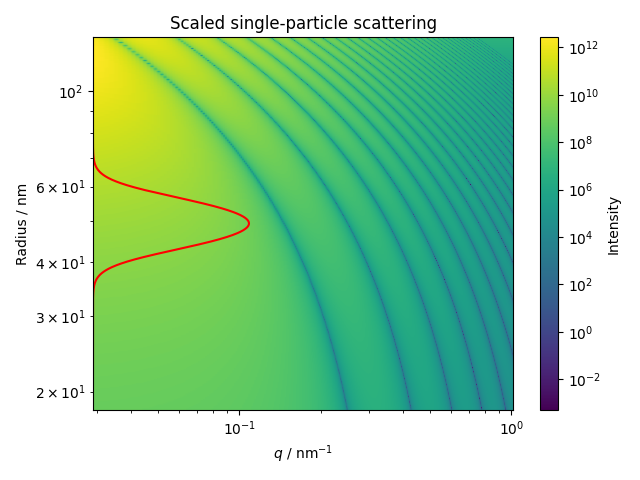

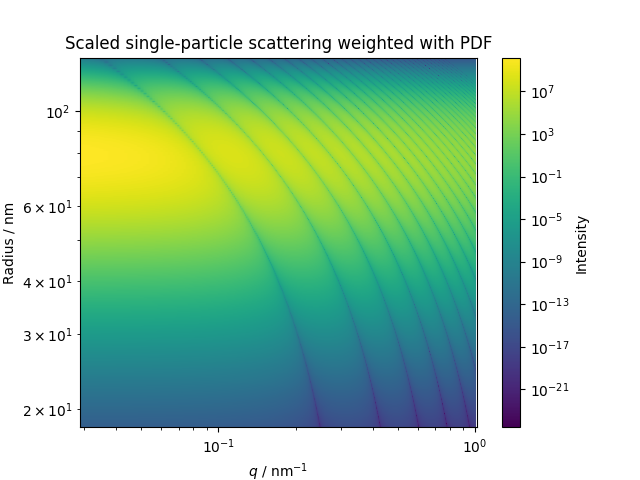

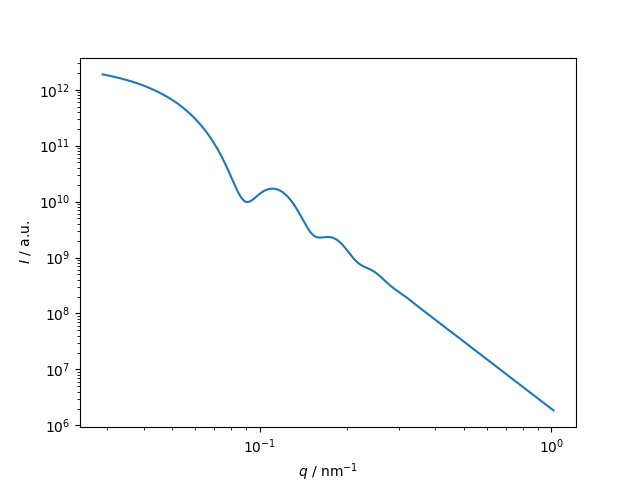

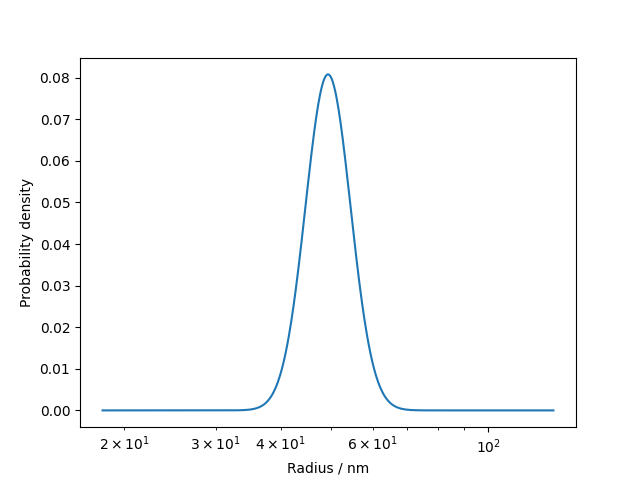

In [12]:
# test distribution
from scipy.stats import norm, lognorm

def lognormal_pdf(mean, std, N=1000, k=10):
    """
    Generate a lognormal PDF on a logarithmically spaced grid.

    Parameters
    ----------
    mu : float
        Mean of the underlying normal distribution (of ln(x)).
    std : float
        Standard deviation of the underlying normal distribution (of ln(x)).
    N : int
        Number of points in the grid.
    k : float
        Range multiplier for how many sigma to include.

    Returns
    -------
    x : ndarray
        Log-spaced grid.
    pdf : ndarray
        Corresponding lognormal PDF values.
    """

    sigma = np.sqrt(np.log(std**2/mean**2 + 1))
    mu = np.log(mean) - (sigma**2)/2
    
    mode = np.exp(mu - sigma**2) # sample around mode for symmetry

    xmin = np.exp(np.log(mode) - k*sigma)
    xmax = np.exp(np.log(mode) + k*sigma)

    # logarithmically spaced grid
    x = np.logspace(np.log10(xmin), np.log10(xmax), N)

    # Scipy uses shape parameter = sigma, scale = exp(mu)
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

    # normalize numerically to ensure ∫pdf dx = 1
    # r and pdf may contain NaNs
    mask = np.isfinite(pdf) * np.isfinite(x)  # True for finite values
    norm = np.trapz(pdf[mask], x[mask])
    pdf /= norm

    return x, pdf

mean = 50 # in nm
std = 5

q = data[:,0] # in nm^-3

radii, pdf = lognormal_pdf(mean, std)

qknown = analyticalsphere[:, 0] 
Ilog   = np.log(analyticalsphere[:,1])

result = np.zeros([len(radii),len(q)])
Iscaled_map = np.zeros([len(radii),len(q)])

selected_dimension_bounding_box = 2.0
volume_of_cloud = 4/3 * np.pi * (selected_dimension_bounding_box / 2)**3

#Summing up single-particle profiles
for i, radius in enumerate(radii):
    rscaled = radius / (selected_dimension_bounding_box / 2) 
    qscaled = qknown / rscaled
    Iscaled = np.exp(np.interp(q, qscaled, Ilog)) * (volume_of_cloud * rscaled**3)**2
    Iscaled_map[i, :] = Iscaled
    result[i, :] = Iscaled * pdf[i]

print(len(Iscaled))
print(np.shape(Iscaled_map))
plt.figure()
plt.imshow(Iscaled_map, aspect='auto', extent=[q[0],q[-1],radii[0],radii[-1]], norm=plt.matplotlib.colors.LogNorm(), origin='lower')
plt.loglog(q[0] + pdf/q[-1], radii, 'r')
plt.colorbar(label='Intensity')
plt.ylabel("Radius / nm")
plt.xlabel(r"$q$ / nm$^{-1}$")
plt.yscale('log')
plt.xscale('log')
plt.title('Scaled single-particle scattering')
plt.xlim(xmin=q[0])
plt.tight_layout()

# plt.loglog(np.sum(result, axis=0), q, 'r')

plt.figure()
plt.imshow(result, aspect='auto', extent=[q[0],q[-1],radii[0],radii[-1]] ,norm=plt.matplotlib.colors.LogNorm(), origin='lower')
plt.colorbar(label='Intensity')
plt.yscale('log')
plt.xscale('log')
plt.ylabel("Radius / nm")
plt.xlabel(r"$q$ / nm$^{-1}$")
plt.title('Scaled single-particle scattering weighted with PDF')

plt.figure()
plt.loglog(q, np.sum(result, axis=0))
plt.xlabel(r"$q$ / nm$^{-1}$")
plt.ylabel(r"$I$ / a.u.")

plt.figure()
plt.semilogx(radii, pdf)
plt.xlabel("Radius / nm")
plt.ylabel("Probability density")

# radius = 50
# rscaled = radius / (selected_dimension_bounding_box / 2) 
# qscaled = qknown / rscaled
# Iscaled1 = np.exp(np.interp(q, qscaled, Ilog)) * (volume_of_cloud * rscaled**3)**2
# radius = 25
# rscaled = radius / (selected_dimension_bounding_box / 2) 
# qscaled = qknown / rscaled
# Iscaled2 = np.exp(np.interp(q, qscaled, Ilog)) * (volume_of_cloud * rscaled**3)**2

# plt.figure()
# plt.loglog(q, Iscaled1)
# plt.loglog(q, Iscaled2)
# idx_mean = np.argmin(np.abs(radii - mean))
# plt.loglog(q, Iscaled_map[idx_mean,:], ':')
# print(radii)

In [8]:
print(np.zeros([len([1,2]), 100]))
print(q)
print(f"len(q) = {len(q)}")
print(f"len(radii) = {len(radii)}")
print(qknown)
print(radii)
print(np.argmin(np.abs(radii - 50)))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
[0.02892838 0.03030592 0.03168346 0.033061   0.03443855 0.03581609
 0.03719363 0.03857117 0.03994871 0.04132626 0.0427038  0.04408134
 0.04545888 0.04683642 0.04821396 0.04959151 0.05096905 0.05234659
 0.05372413 0.05510168 0.05647922 0.05785676 0.0592343  0.06061184
 0.06198938 0.06336692 0.06474447 0.06612201 0.06749955 0.0688771
 0.07025463 0.07163218 0.07300972 0.0743872